In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import scipy.stats as st
from functools import reduce

import timeit
import gseapy as gp

from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

## Bulk RNA Sequencing Processing

In [2]:
def read_process_data(fName):
    
    df = pd.read_csv(fName)
    
    # make first row into the index
    df = df.set_index(df.iloc[:, 0].values)
    
    # keep all but the first row because now it's the index
    df = df.iloc[:, 1:]
    
    # name the index
    #df.index.name = "Broad ID"
    
    print(df.shape)
    
    return df

In [3]:
# cn = copy number
df_cn = read_process_data("data/CCLE_gene_cn.csv")

# 27562 Genes
# 1741 Cell Lines
# 35 Primary Diseases
# 37 Lineages

# bulk expression data
df_expr = read_process_data("data/CCLE_expression.csv")

# 19177 Genes
# 1377 Cell Lines
# 33 Primary Diseases
# 37 Lineages

df_metadata = pd.read_csv("data/sample_info.csv")
df_locus = pd.read_csv("data/gene_locus.csv")

(1741, 27562)
(1377, 19177)


In [4]:
def intersect_remove_HLA(df_cn, df_expr, df_metadata, df_locus):
    
    df_metadata = df_metadata.loc[~pd.isnull(df_metadata["CCLE_Name"])]
    
    df_cn = df_cn.loc[np.intersect1d(df_cn.index, df_metadata["DepMap_ID"])]
    
    # keep cell lines present in both dataframes because df_cn is the ground truth and df_expr is what we're inferring CN from
    df_cn_keep = df_cn.loc[np.intersect1d(df_cn.index, df_expr.index), np.intersect1d(df_cn.columns, df_expr.columns)]
    df_expr_keep = df_expr.loc[np.intersect1d(df_cn.index, df_expr.index), np.intersect1d(df_cn.columns, df_expr.columns)]
     
    genes, entrez_id = list(zip(*df_expr_keep.columns.str.split(" ")))
    
    # simplify column names
    df_expr_keep.columns = genes
    df_cn_keep.columns = genes    

    # remove HLA genes like they did in their workflow
    df_cn_keep = df_cn_keep.loc[:, ~df_cn_keep.columns.str.contains("HLA")]
    df_expr_keep = df_expr_keep.loc[:, ~df_expr_keep.columns.str.contains("HLA")]
    
    common_genes = reduce(np.intersect1d, (df_cn_keep.columns, df_expr_keep.columns, df_locus["HGNC.symbol"].values))

    df_expr_keep = df_expr_keep[common_genes]
    df_cn_keep = df_cn_keep[common_genes]
    
    # this one is a little longer than the others because there are some repeated genes
    df_locus_keep = df_locus.loc[df_locus["HGNC.symbol"].isin(common_genes), :]
    
    # keep only the metadata rows (cell lines) in df_cn_keep
    df_metadata_keep = df_metadata.loc[(df_metadata["DepMap_ID"].isin(df_cn_keep.index))]
    
    return df_cn_keep-1, df_expr_keep, df_metadata_keep.reset_index(drop=True), df_locus_keep

In [5]:
CN, expr, metadata, gene_loci = intersect_remove_HLA(df_cn, df_expr, df_metadata, df_locus)

In [6]:
# relative expression (RE), normalizing each sample's expression for each gene to the average for that gene
rel_expr = (expr-expr.mean())

# replace values outside the range (-3, 3) with -3 or 3, as they did in the paper
rel_expr = rel_expr[(rel_expr <= 3)].fillna(3)
rel_expr = rel_expr[(rel_expr >= -3)].fillna(-3)

# sort genes by their chromosomal location -- first by chromosome, then by the karyotype band
# alternating light and dark stripes that appear along the lengths of chromosomes. Each chromosome has a unique banding pattern, so band is another location along a chromosome
sorted_genes = gene_loci.sort_values(by=["Chromosome.scaffold.name", "Karyotype.band"])["HGNC.symbol"].drop_duplicates().values

In [7]:
def highest_genes(num_highest):
    
    # indices of highest average relative gene expression, take 1000
    indices_highest = np.argsort(rel_expr.mean()).values[::-1][:num_highest]

    # get the high genes from just one dataframe (because they are all in the same order)
    high_genes = rel_expr.iloc[:, indices_highest].columns

    # arrange the high genes according to chromosomal order
    sorted_genes_high = [gene for gene in sorted_genes if gene in high_genes]

    # rearrange dataframes according to chromosomal order
    RE_high = rel_expr[sorted_genes_high]
    expr_high = expr[sorted_genes_high]
    CN_high = CN[sorted_genes_high]
    
    return RE_high, expr_high, CN_high

In [8]:
RE_high, expr_high, CN_high = highest_genes(7000)

In [9]:
tissues_only = [metadata.CCLE_Name.values[i].split("_", 1)[-1] for i in range(len(metadata))]

print(f"{len(np.unique(tissues_only))} tissue types")

# dictionary of the tissues that each cell line comes from
tissue_cell_lines = dict(zip(RE_high.index, tissues_only))

RE_high["Tissue"] = tissues_only
CN_high["Tissue"] = tissues_only

38 tissue types


/var/folders/mm/bx_h3x157735lh27_3pyt4km0000gn/T/ipykernel_1735/3554079424.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RE_high["Tissue"] = tissues_only
/var/folders/mm/bx_h3x157735lh27_3pyt4km0000gn/T/ipykernel_1735/3554079424.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CN_high["Tissue"] = tissues_only


In [15]:
def correlations_by_tissue(tissue_type):
        
    tissue_re = RE_high.loc[RE_high.Tissue == tissue_type].select_dtypes(include=float)
    tissue_cn = CN_high.loc[CN_high.Tissue == tissue_type].select_dtypes(include=float)
    
    corrs_lst = [st.spearmanr(tissue_re[col], tissue_cn[col])[0] for col in tissue_re.columns]
    
    #return pd.DataFrame(corrs_lst).dropna().mean()[0]
    return corrs_lst

In [16]:
df_corrs = pd.DataFrame({"Gene": RE_high.columns[:-1]})

In [17]:
for tissue in np.unique(tissues_only):

    df_corrs[tissue] = correlations_by_tissue(tissue)

/Users/skulkarni/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [18]:
tissue_corr_df = pd.DataFrame(dict(zip(np.unique(tissues_only), 
                                       df_corrs.select_dtypes(include=float).mean().fillna(0).values)),
                             index=[0]).T.reset_index()

tissue_corr_df.columns = ["Tissue", "Mean Correlation"]
tissue_corr_df = tissue_corr_df.sort_values(by="Mean Correlation", ascending=False)

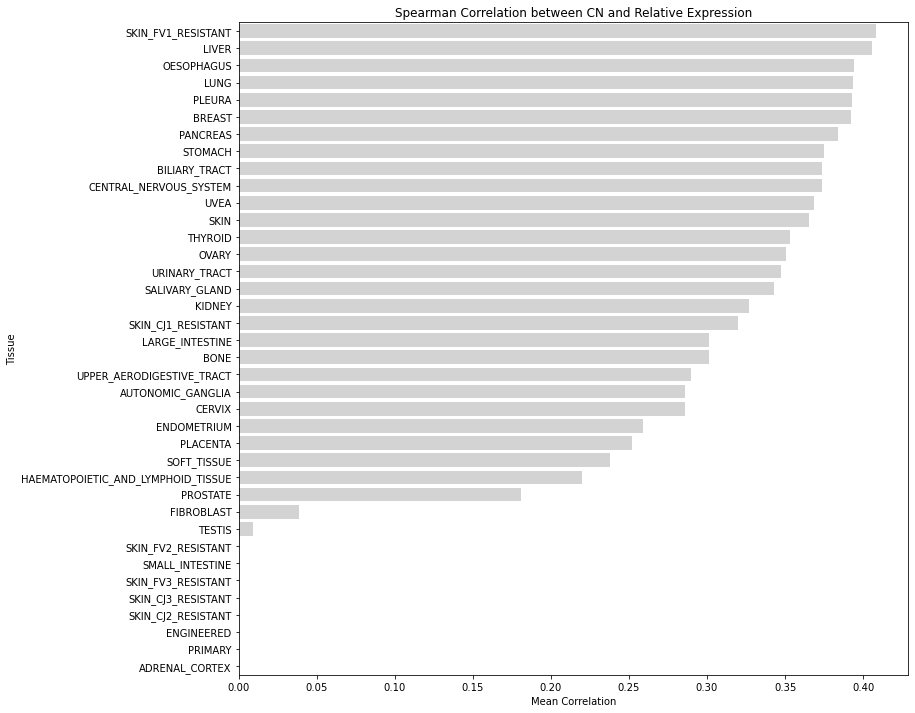

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.barplot(data=tissue_corr_df, x="Mean Correlation", y="Tissue", 
            #color='#1f77b4', 
            color="lightgray",
            ax=ax)
ax.set_title("Spearman Correlation between CN and Relative Expression")
plt.show()

## Gene Set Enrichment Analysis (GSEA)

GSEA works only with 2 phenotypes at a time, so use power matching to compare tissue types. There are 38 tissue types, so perform GSEA 19 times. 

For GSEA, columns need to be cell lines, and rows are genes. The first two columns are "Name" and "Description". "Name" is the gene name; "Description" is the description of each gene, but it can be filled with placeholder values like NaNs or 0s.

In [20]:
df_feat_gsea = RE_high.iloc[:, :-1].T

# add Name and Description columns
df_feat_gsea["Name"] = df_feat_gsea.index
df_feat_gsea["Description"] = np.zeros(len(df_feat_gsea)).astype(int)

# rearrange columns so that Name and Description are at the beginning
df_feat_gsea = df_feat_gsea[["Name", "Description"] + list(df_feat_gsea.columns[:-2])]

# check dataframe
df_feat_gsea.head()

,Name,Description,ACH-000001,ACH-000002,ACH-000003,ACH-000004,ACH-000005,ACH-000006,ACH-000007,ACH-000008,...,ACH-002458,ACH-002459,ACH-002460,ACH-002461,ACH-002465,ACH-002508,ACH-002509,ACH-002510,ACH-002511,ACH-002512
FAM72B,FAM72B,0,-0.034053,0.558801,-2.807521,1.064076,2.124398,1.666590,-0.791828,-0.416923,...,-0.434221,-1.243753,-1.023541,-0.987343,-1.023541,-0.932233,-0.142186,-2.900631,0.134993,2.359646
PHGDH,PHGDH,0,1.795467,-1.757593,0.224101,2.231971,1.051945,2.199008,-3.000000,0.528106,...,-1.352554,-2.804219,-1.063907,-0.513451,0.752385,1.326677,0.072945,-3.000000,0.270972,2.993823
ADAM30,ADAM30,0,-0.001910,-0.001910,0.012445,-0.001910,-0.001910,-0.001910,-0.001910,-0.001910,...,-0.001910,-0.001910,-0.001910,-0.001910,-0.001910,-0.001910,-0.001910,-0.001910,-0.001910,-0.001910
NOTCH2,NOTCH2,0,1.522724,-2.100931,-1.002999,0.433937,1.116669,-0.015086,-1.414297,1.120725,...,0.451610,1.186583,0.632423,1.035792,0.930498,0.877003,0.047461,-1.969687,0.958787,2.689022
MAN1A2,MAN1A2,0,1.073507,-2.056678,-1.396487,-0.588656,0.402753,-0.079231,-0.391498,0.523009,...,0.577457,0.334134,0.869737,-0.229898,0.301644,-0.738968,0.709476,-1.309220,0.612647,-1.022853


In [21]:
def gsea_two_tissues(tissue1, tissue2):
    
    cell_lines_1 = [key for key in tissue_cell_lines.keys() if tissue_cell_lines[key] == tissue1]
    cell_lines_2 = [key for key in tissue_cell_lines.keys() if tissue_cell_lines[key] == tissue2]
    
    phenotypes_lst = ["1"]*len(cell_lines_1) + ["2"]*len(cell_lines_2)
    
    df_2_tissues = df_feat_gsea[["Name", "Description"] + list(df_feat_gsea.columns[df_feat_gsea.columns.isin(cell_lines_1 + cell_lines_2)])]
    
    gs_res = gp.gsea(data=df_2_tissues, # or data='./P53_resampling_data.txt'
                     gene_sets='KEGG_2016', # enrichr library names
                     cls=phenotypes_lst, # cls=class_vector
                     # set permutation_type to phenotype if samples >=15
                     permutation_type='phenotype',
                     permutation_num=100, # reduce number to speed up test
                     outdir=None,  # do not write output to disk
                     no_plot=False, # Skip plotting
                     method='signal_to_noise',
                     processes=4, seed= 7,
                     format='png')
    
    return gs_res

In [22]:
def plot_gsea_results(gs_res):
    
    # plotting heatmap
    genes = gs_res.res2d.genes[0].split(";")
    terms = gs_res.res2d.index
    
    # Make sure that ``ofname`` is not None, if you want to save your figure to disk
    gp.plot.heatmap(df = gs_res.heatmat.loc[genes], z_score=0, title=terms[0], figsize=(18, 6))

In [23]:
corr_nonzero = tissue_corr_df.loc[tissue_corr_df["Mean Correlation"] > 0].reset_index(drop=True)
index_pairs = [[i, len(corr_nonzero)-1-i] for i in range(int(len(corr_nonzero) / 2))]

In [99]:
gsea_pairs = []

start = timeit.default_timer()

for i in range(len(index_pairs))
    tissue1, tissue2 = corr_nonzero.iloc[index_pairs[i], :].Tissue.values
    gsea_pairs.append(gsea_two_tissues(tissue1, tissue2))
    
end = timeit.default_timer()
print(f"{end-start} seconds")

2021-11-22 10:46:59,836 Warning: No enrich terms using library KEGG_2016 when cutoff = 0.5
2021-11-22 10:47:13,302 Warning: No enrich terms using library KEGG_2013 when cutoff = 0.5


# Supplementary Figures

## Gene Pair-Wise Correlations Between Relative Expression and CNA (1000 Highest Genes)

In [16]:
genes = list(RE_high.columns)
correlations = []

for col1 in RE_high.columns:
    
    single_gene_corr = [] 

    for col2 in CN_high.columns:

        single_gene_corr.append(st.spearmanr(RE_high[col1], CN_high[col2])[0])
    
    # print progress
    if genes.index(col1) % 100 == 0:
        print(col1)
    
    correlations.append(single_gene_corr)

PHGDH
POLE4
CEP70
PPT2
PRKAG2
HPS1
EPS8
GOLGA8A
PCTP
ZNF544


In [17]:
df_corr_1000 = pd.DataFrame(correlations)
df_corr_1000.columns = RE_high.columns
df_corr_1000.index = RE_high.columns

# rearrange the columns to be the other way
df_corr_1000 = df_corr_1000[df_corr_1000.columns[::-1]]

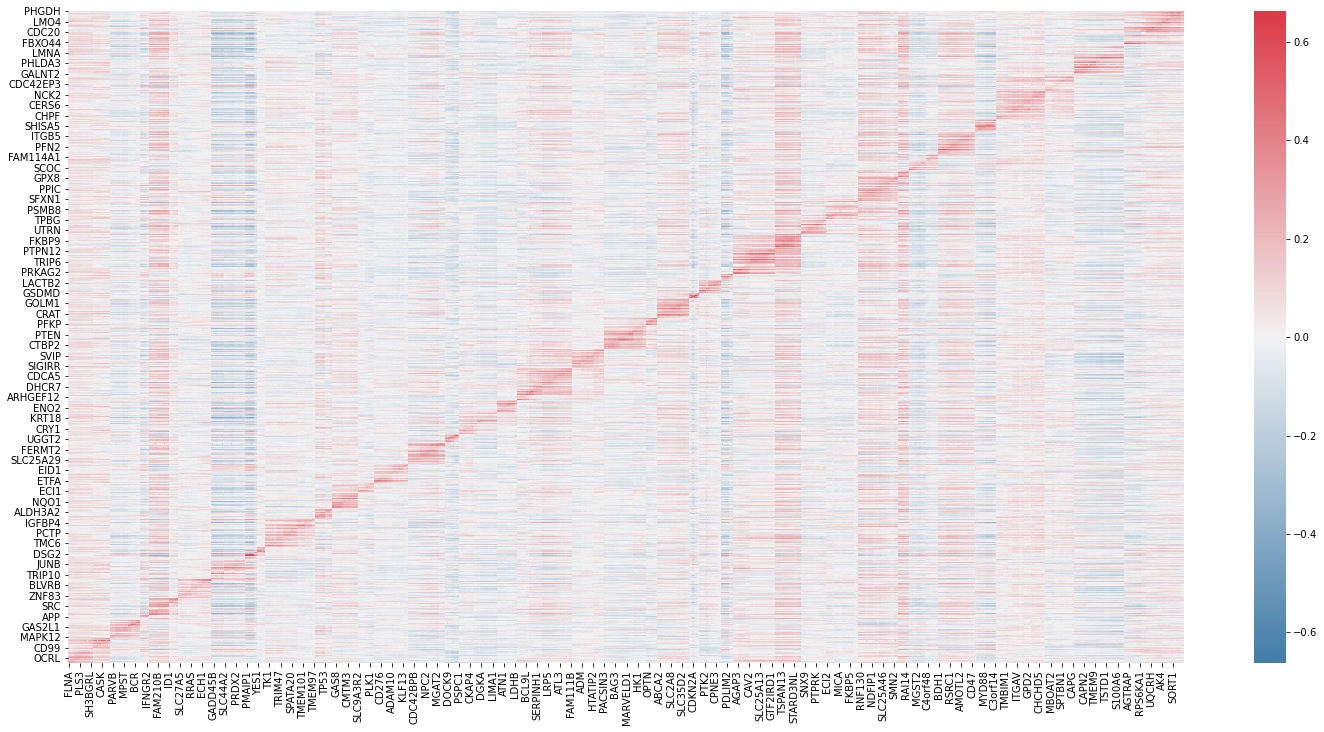

In [23]:
fig, ax = plt.subplots(figsize=(25, 12))
max_val = np.max(np.max(df_corr_1000))

palette = sns.diverging_palette(240, 10, as_cmap=True)

sns.heatmap(df_corr_1000, vmin=-max_val, vmax=max_val, 
            cmap=palette, 
            ax=ax)

#ax.set_title("Spearman Correlations between Copy Number and Expression Across CCLE Cell Lines")
#plt.savefig("spearman_corr.png")
plt.show()

## Heatmap of log2(CN/2) by Tissue Type (7000 Highest Genes)

In [21]:
RE_high, expr_high, CN_high = highest_genes(7000)

# make a dictionary mapping each gene to the chromosomal arm it's in
gene_arm_dict = dict(zip(gene_loci["HGNC.symbol"], gene_loci["chr.arm"]))
chr_arms = [gene_arm_dict[gene] for gene in CN_high.columns]

chr_arms_df = pd.DataFrame(chr_arms).T
chr_arms_df.columns = CN_high.columns

CN_high = CN_high.append(chr_arms_df).rename(index={0: "chr_arm"})

CN_transposed = CN_high.T.convert_dtypes()

# replace single digit numbers with 0 followed by number to sort properly
split_names = CN_transposed["chr_arm"].str.split('(\d+)').values
arms = [name[-1] for name in split_names]
chroms = ["0" + name[1] if len(name[1]) == 1 else name[1] for name in split_names]

new_names = [chrom + arm for chrom, arm in zip(chroms, arms)]
CN_transposed["chr_arm"] = new_names

RE_transposed = RE_high.T
RE_transposed["chr_arm"] = new_names

grouped_CN = CN_transposed.groupby("chr_arm").mean()

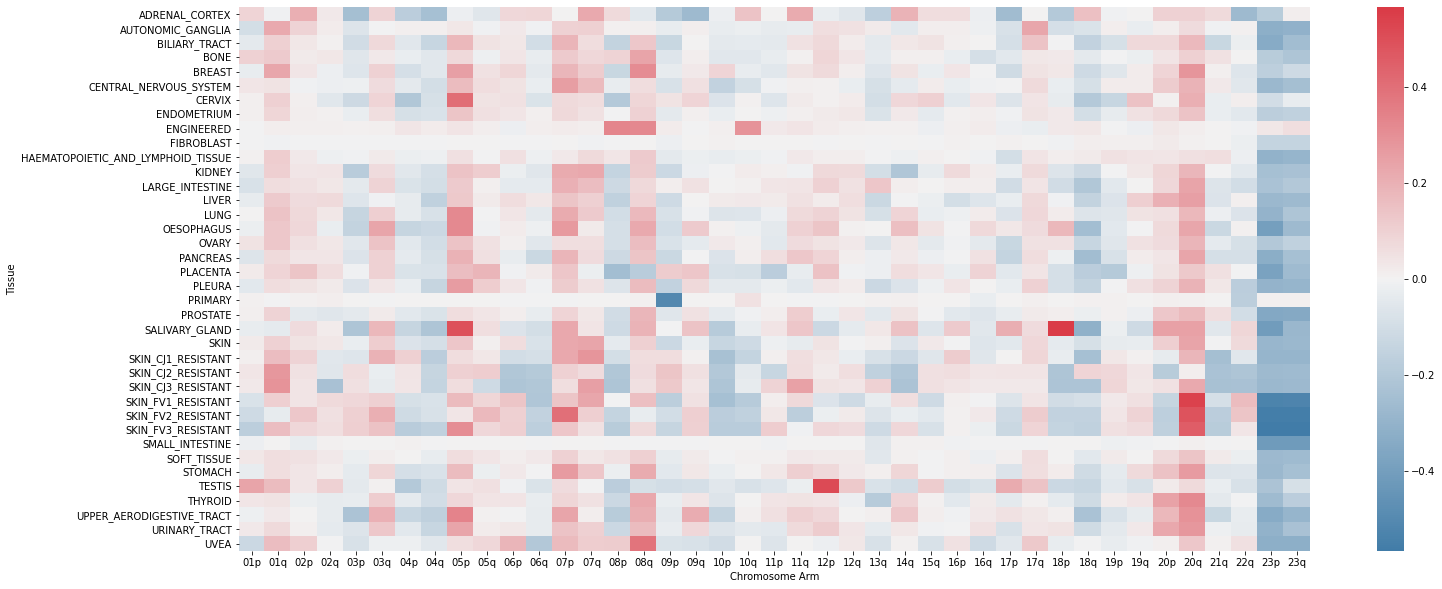

In [24]:
split_tissues = metadata["CCLE_Name"].dropna().str.split("_", 1).values
tissues_only = [split[-1] for split in split_tissues]

df_hm = grouped_CN.T
df_hm["tissue_type"] = tissues_only

#plot_df = cna_full_by_arm.groupby("chr_arm").mean()
#plot_df = test.astype(float)
plot_df = df_hm.groupby("tissue_type").mean().astype(float)

max_val = abs(plot_df).values.max()
fig, ax = plt.subplots(figsize=(24, 10))

#palette = sns.color_palette("coolwarm", as_cmap=True)
palette = sns.diverging_palette(240, 10, as_cmap=True)

sns.heatmap(plot_df, cmap=palette, vmin=-max_val, vmax=max_val, ax=ax)
ax.set_xlabel("Chromosome Arm")
ax.set_ylabel("Tissue")
plt.savefig("figures/cn_heatmap.png")
#plt.show()